GPU acceleration in place powered by TensorFlow (GPU)


2024-06-08 17:05:18.856174: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-08 17:05:18.856321: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-08 17:05:18.856339: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-08 17:05:18.856418: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-08 17:05:18.856474: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-06-08 17:05:20.569420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - accuracy: 0.2562 - loss: 1.9763 - val_accuracy: 0.4784 - val_loss: 1.4140 - learning_rate: 0.0010
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - accuracy: 0.4425 - loss: 1.5291 - val_accuracy: 0.5226 - val_loss: 1.3650 - learning_rate: 0.0010
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.4952 - loss: 1.4130 - val_accuracy: 0.5772 - val_loss: 1.1779 - learning_rate: 0.0010
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - accuracy: 0.5393 - loss: 1.3053 - val_accuracy: 0.5970 - val_loss: 1.1760 - learning_rate: 0.0010
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - accuracy: 0.5558 - loss: 1.2520 - val_accuracy: 0.6033 - val_loss: 1.0912 - learning_rate: 0.0010
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.5798 - loss: 1.1904 - val_accuracy: 0.6366 - val_loss: 1.0533 - learning_rate: 0.0010
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.5962 - loss: 1.159

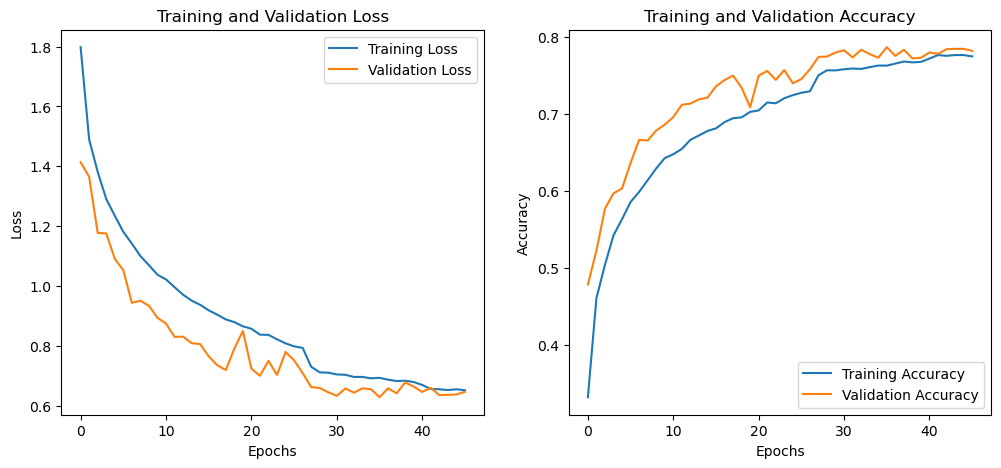

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Detailed Statistics:
Test Accuracy: 78.69%
Precision: 0.79
Recall: 0.79
F1 Score: 0.78


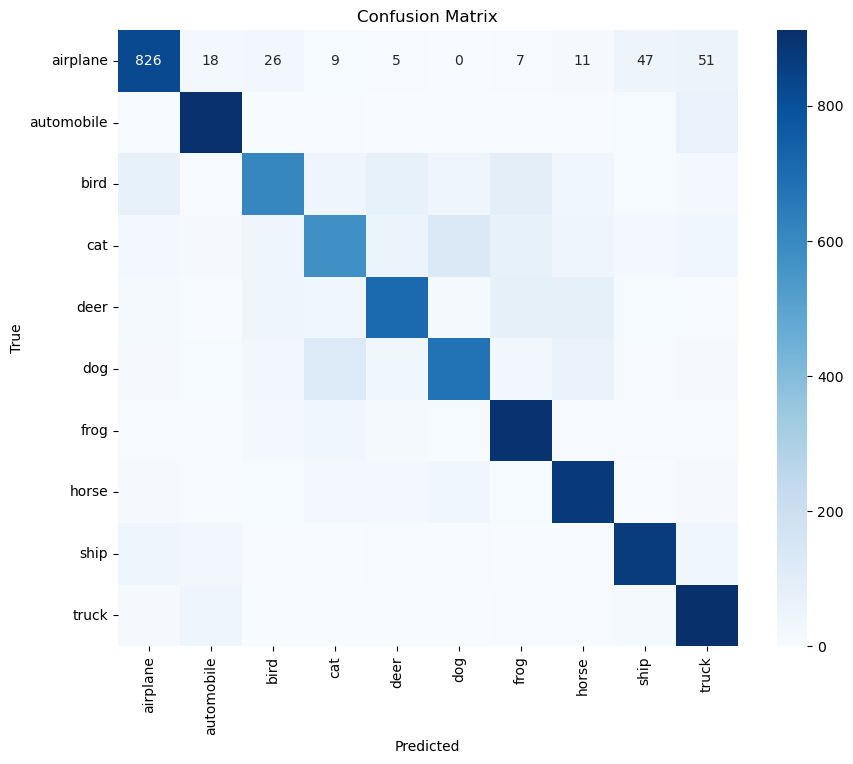

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    return accuracy, precision, recall, f1

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Check available devices
physical_devices = tf.config.list_physical_devices()
if "GPU" in [device.device_type for device in physical_devices]:
    device_info = "GPU acceleration in place powered by TensorFlow (GPU)"
else:
    device_info = "Using CPU... Best of luck..."
print(device_info)

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# Define the model
model = models.Sequential([
    Input(shape=(32, 32, 3)),  # Using Input layer to specify the input shape
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer for regularization
    layers.Dense(10, activation='softmax')  # Softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Set up early stopping and learning rate reduction on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model with augmented data
history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                    epochs=50,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

# Plot the training curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# Make predictions
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Calculate evaluation metrics
accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred)

# Print detailed statistics
print("Detailed Statistics:")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot confusion matrix
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(y_test, y_pred, classes)